# FML Challenge 2: Supervised Learning

Team: Mohammed Dahbani, Laudereau Louis, Sam Ghyselen, Kela Wydie Nessesy, Ble Baka-Junior, Thibault Martinez

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import chi2
from sklearn import preprocessing

## **Phase 1: Warm-Up Analysis**

### **1-Data Preparation**

- We import the dataset
- We split the data between the features and the target
- We remove the following variables from the analysis as instructed :
        - `FILENAME`(can be ignored)
        - `URLSimilarityIndex`
        - `CharContinuationRate`
        - `URLTitleMatchScore`
        - `URLCharProb`
        - `TLDLegitimateProb`

In [ ]:
! pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
repo = fetch_ucirepo(id=967)

# data (as pandas dataframes)
X = repo.data.features
y = repo.data.targets

# We drop the column giving too much information

X = X.drop(columns=['URLSimilarityIndex', 'CharContinuationRate', 'URLTitleMatchScore', 'URLCharProb', 'TLDLegitimateProb'])

# We concatenate the features and target into one dataframe for the analysis
ds = pd.concat([X,y],axis=1)

# metadata
print(repo.metadata)

# variable information
print(repo.variables)


{'uci_id': 967, 'name': 'PhiUSIIL Phishing URL (Website)', 'repository_url': 'https://archive.ics.uci.edu/dataset/967/phiusiil+phishing+url+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/967/data.csv', 'abstract': 'PhiUSIIL Phishing URL Dataset is a substantial dataset comprising 134,850 legitimate and 100,945 phishing URLs. Most of the URLs we analyzed, while constructing the dataset, are the latest URLs. Features are extracted from the source code of the webpage and URL. Features such as CharContinuationRate, URLTitleMatchScore, URLCharProb, and TLDLegitimateProb are derived from existing features.', 'area': 'Computer Science', 'tasks': ['Classification'], 'characteristics': ['Tabular'], 'num_instances': 235795, 'num_features': 54, 'feature_types': ['Real', 'Categorical', 'Integer'], 'demographics': [], 'target_col': ['label'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2024, 'last_updated': 'Sun May 12 

#### NOTE: For the Target Variable **Label 1** corresponds to a **legitimate URL**, **label 0** to a **phishing URL**

### **2- Descriptive statistics and feature engineering**

#### **2.1- Data Quality Assessment**

In [ ]:
ds.head()

,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,TLDLength,NoOfSubDomain,HasObfuscation,NoOfObfuscatedChar,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,3,1,0,0,...,0,0,1,34,20,28,119,0,124,1
1,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,2,1,0,0,...,0,0,1,50,9,8,39,0,217,1
2,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,2,2,0,0,...,0,0,1,10,2,7,42,2,5,1
3,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,3,1,0,0,...,1,1,1,3,27,15,22,1,31,1
4,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,3,1,0,0,...,1,0,1,244,15,34,72,1,85,1


In [ ]:
y.head()

,label
0,1
1,1
2,1
3,1
4,1


The dataset description asserts that there are **no missing values**. We can also verify this by running the code below:

In [ ]:
ds.isna().sum()

,0
URL,0
URLLength,0
Domain,0
DomainLength,0
IsDomainIP,0
TLD,0
TLDLength,0
NoOfSubDomain,0
HasObfuscation,0
NoOfObfuscatedChar,0


#### **2.2- Summarize individual features (mean, median, mode, standard deviation, etc.).**

In [ ]:
ds.describe()

,URLLength,DomainLength,IsDomainIP,TLDLength,NoOfSubDomain,HasObfuscation,NoOfObfuscatedChar,ObfuscationRatio,NoOfLettersInURL,LetterRatioInURL,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
count,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,...,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000
mean,34.573095,21.470396,0.002706,2.764456,1.164758,0.002057,0.024861,0.000138,19.428919,0.515946,...,0.237007,0.023474,0.486775,26.075689,6.333111,10.522305,65.071113,2.377629,49.262516,0.571895
std,41.314153,9.150793,0.051946,0.599739,0.600969,0.045306,1.876249,0.003817,29.090330,0.123315,...,0.425247,0.151403,0.499826,79.411815,74.866296,22.312192,176.687539,17.641097,161.027430,0.494805
min,13.000000,4.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,16.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,10.000000,0.435000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,27.000000,20.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,14.000000,0.519000,...,0.000000,0.000000,0.000000,8.000000,2.000000,6.000000,12.000000,0.000000,10.000000,1.000000
75%,34.000000,24.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,20.000000,0.594000,...,0.000000,0.000000,1.000000,29.000000,8.000000,15.000000,88.000000,1.000000,57.000000,1.000000
max,6097.000000,110.000000,1.000000,13.000000,10.000000,1.000000,447.000000,0.348000,5191.000000,0.926000,...,1.000000,1.000000,1.000000,8956.000000,35820.000000,6957.000000,27397.000000,4887.000000,27516.000000,1.000000


#### **2.3- Data Analysis**

In [ ]:
ds.head()

,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,TLDLength,NoOfSubDomain,HasObfuscation,NoOfObfuscatedChar,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,3,1,0,0,...,0,0,1,34,20,28,119,0,124,1
1,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,2,1,0,0,...,0,0,1,50,9,8,39,0,217,1
2,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,2,2,0,0,...,0,0,1,10,2,7,42,2,5,1
3,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,3,1,0,0,...,1,1,1,3,27,15,22,1,31,1
4,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,3,1,0,0,...,1,0,1,244,15,34,72,1,85,1


In [ ]:
#Example of phising site
ds[ds['label']== 0].head(10)

,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,TLDLength,NoOfSubDomain,HasObfuscation,NoOfObfuscatedChar,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
11,http://www.teramill.com,22,www.teramill.com,16,0,com,3,1,0,0,...,0,0,0,0,0,0,0,0,1,0
20,http://www.f0519141.xsph.ru,26,www.f0519141.xsph.ru,20,0,ru,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0
21,http://www.shprakserf.gq,24,www.shprakserf.gq,17,0,gq,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
27,https://service-mitld.firebaseapp.com/,37,service-mitld.firebaseapp.com,29,0,com,3,1,0,0,...,0,0,0,0,0,0,0,0,0,0
28,http://www.kuradox92.lima-city.de,32,www.kuradox92.lima-city.de,26,0,de,2,2,0,0,...,0,0,0,1,0,0,1,0,1,0
29,https://liuy-9a930.web.app/,26,liuy-9a930.web.app,18,0,app,3,1,0,0,...,0,0,0,0,0,0,0,0,3,0
31,https://ipfs.io/ipfs/qmrvvyr84esa2assw9vvwupqj...,91,ipfs.io,7,0,io,2,0,0,0,...,0,0,0,0,5,6,0,0,2,0
32,http://att-103731-107123.weeblysite.com/,40,att-103731-107123.weeblysite.com,32,0,com,3,1,0,0,...,0,0,0,0,0,0,1,0,1,0
34,https://hidok4f8zl.firebaseapp.com/,35,hidok4f8zl.firebaseapp.com,26,0,com,3,1,0,0,...,0,0,0,0,0,0,0,0,3,0
37,http://www.ooguy.com,19,www.ooguy.com,13,0,com,3,1,0,0,...,0,0,0,0,0,0,1,0,1,0


In [ ]:
#Example of legitimate site
ds[ds['label']== 1].head(10)

,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,TLDLength,NoOfSubDomain,HasObfuscation,NoOfObfuscatedChar,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,3,1,0,0,...,0,0,1,34,20,28,119,0,124,1
1,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,2,1,0,0,...,0,0,1,50,9,8,39,0,217,1
2,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,2,2,0,0,...,0,0,1,10,2,7,42,2,5,1
3,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,3,1,0,0,...,1,1,1,3,27,15,22,1,31,1
4,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,3,1,0,0,...,1,0,1,244,15,34,72,1,85,1
5,https://www.globalreporting.org,30,www.globalreporting.org,23,0,org,3,1,0,0,...,0,0,1,35,1,11,86,0,14,1
6,https://www.saffronart.com,25,www.saffronart.com,18,0,com,3,1,0,0,...,0,0,1,32,4,14,44,2,17,1
7,https://www.nerdscandy.com,25,www.nerdscandy.com,18,0,com,3,1,0,0,...,0,0,1,24,2,22,36,0,15,1
8,https://www.hyderabadonline.in,29,www.hyderabadonline.in,22,0,in,2,1,0,0,...,0,0,1,71,4,9,40,1,317,1
9,https://www.aap.org,18,www.aap.org,11,0,org,3,1,0,0,...,0,0,1,10,1,12,173,6,65,1


In [ ]:
col_binary = ['IsDomainIP', 'HasObfuscation', 'IsHTTPS', 'HasTitle', 'HasFavicon', 'Robots', 'IsResponsive', 'HasDescription', 'HasExternalFormSubmit', 'HasSocialNet',
              'HasSubmitButton','HasHiddenFields', 'HasPasswordField', 'Bank', 'Pay', 'Crypto', 'HasCopyrightInfo']
print(len(col_binary))
col_numerical = ['URLLength', 'DomainLength', 'TLDLength', 'NoOfSubDomain', 'NoOfObfuscatedChar', 'ObfuscationRatio', 'NoOfLettersInURL', 'LetterRatioInURL',
                 'NoOfDegitsInURL', 'DegitRatioInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL', 'SpacialCharRatioInURL',
                 'LineOfCode', 'LargestLineLength', 'DomainTitleMatchScore', 'NoOfURLRedirect', 'NoOfSelfRedirect', 'NoOfPopup', 'NoOfiFrame', 'NoOfImage', 'NoOfCSS', 'NoOfJS',
                 'NoOfSelfRef', 'NoOfEmptyRef', 'NoOfExternalRef']
print(len(col_numerical))
col_categorical = ['URL', 'Domain', 'TLD', 'Title']
print(len(col_categorical))

17
28
4


#### **2.4- Data visualisation**

##### 2.4.1-Bar plot

- Distribution of Labels: Phishing (0) vs. Legitimate (1) URLs

<Axes: xlabel='label', ylabel='count'>

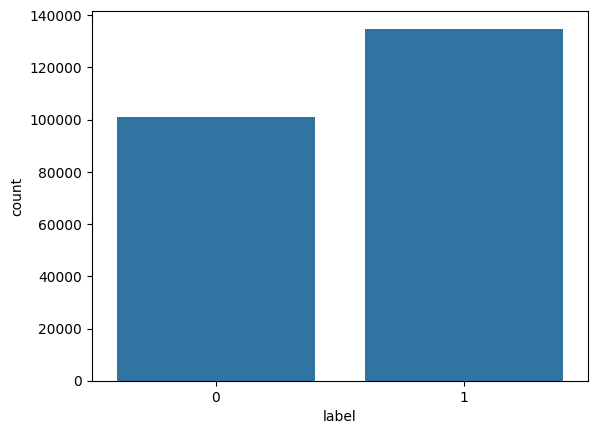

In [ ]:
sns.countplot(x='label', data=ds)

- Bar plot for binary features by label

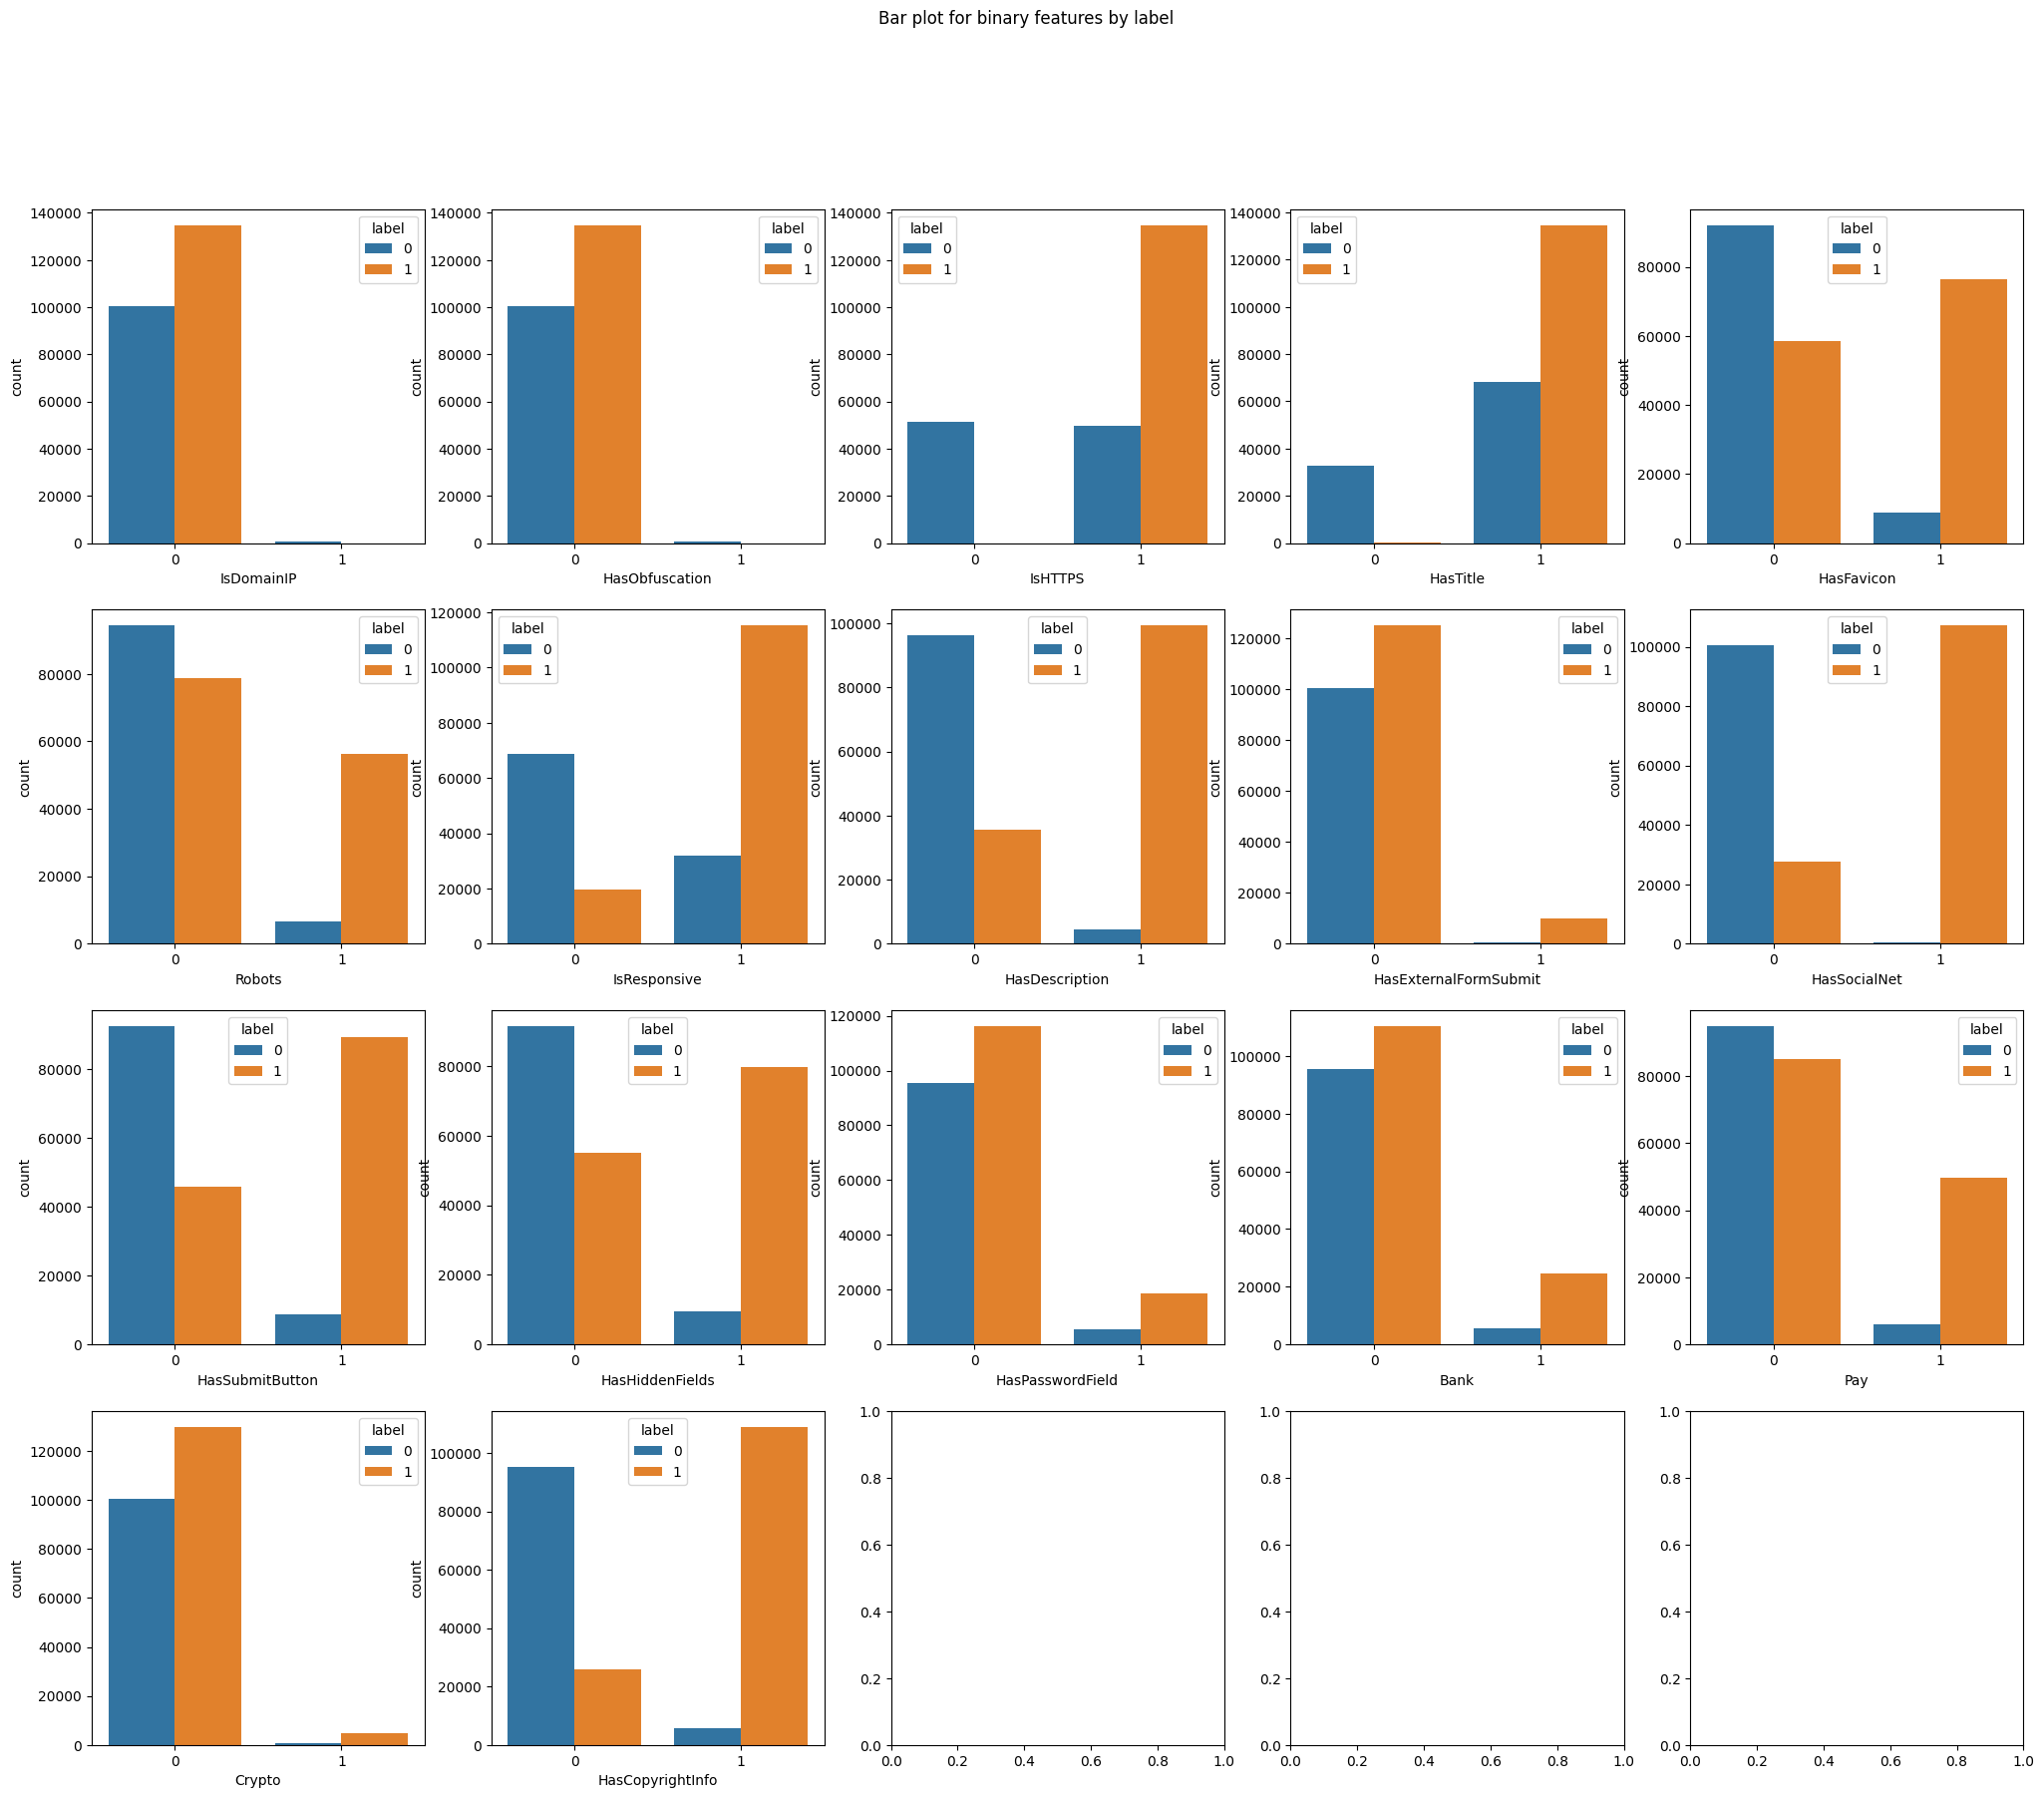

In [ ]:
fig, axs = plt.subplots(4, 5, figsize=(25, 20))
fig.suptitle('Bar plot for binary features by label')

for i, col in enumerate(col_binary):
    sns.countplot(x=col, hue='label', data=ds, ax=axs[i//5, i%5])

plt.show()

##### 2.4.2-Box plot

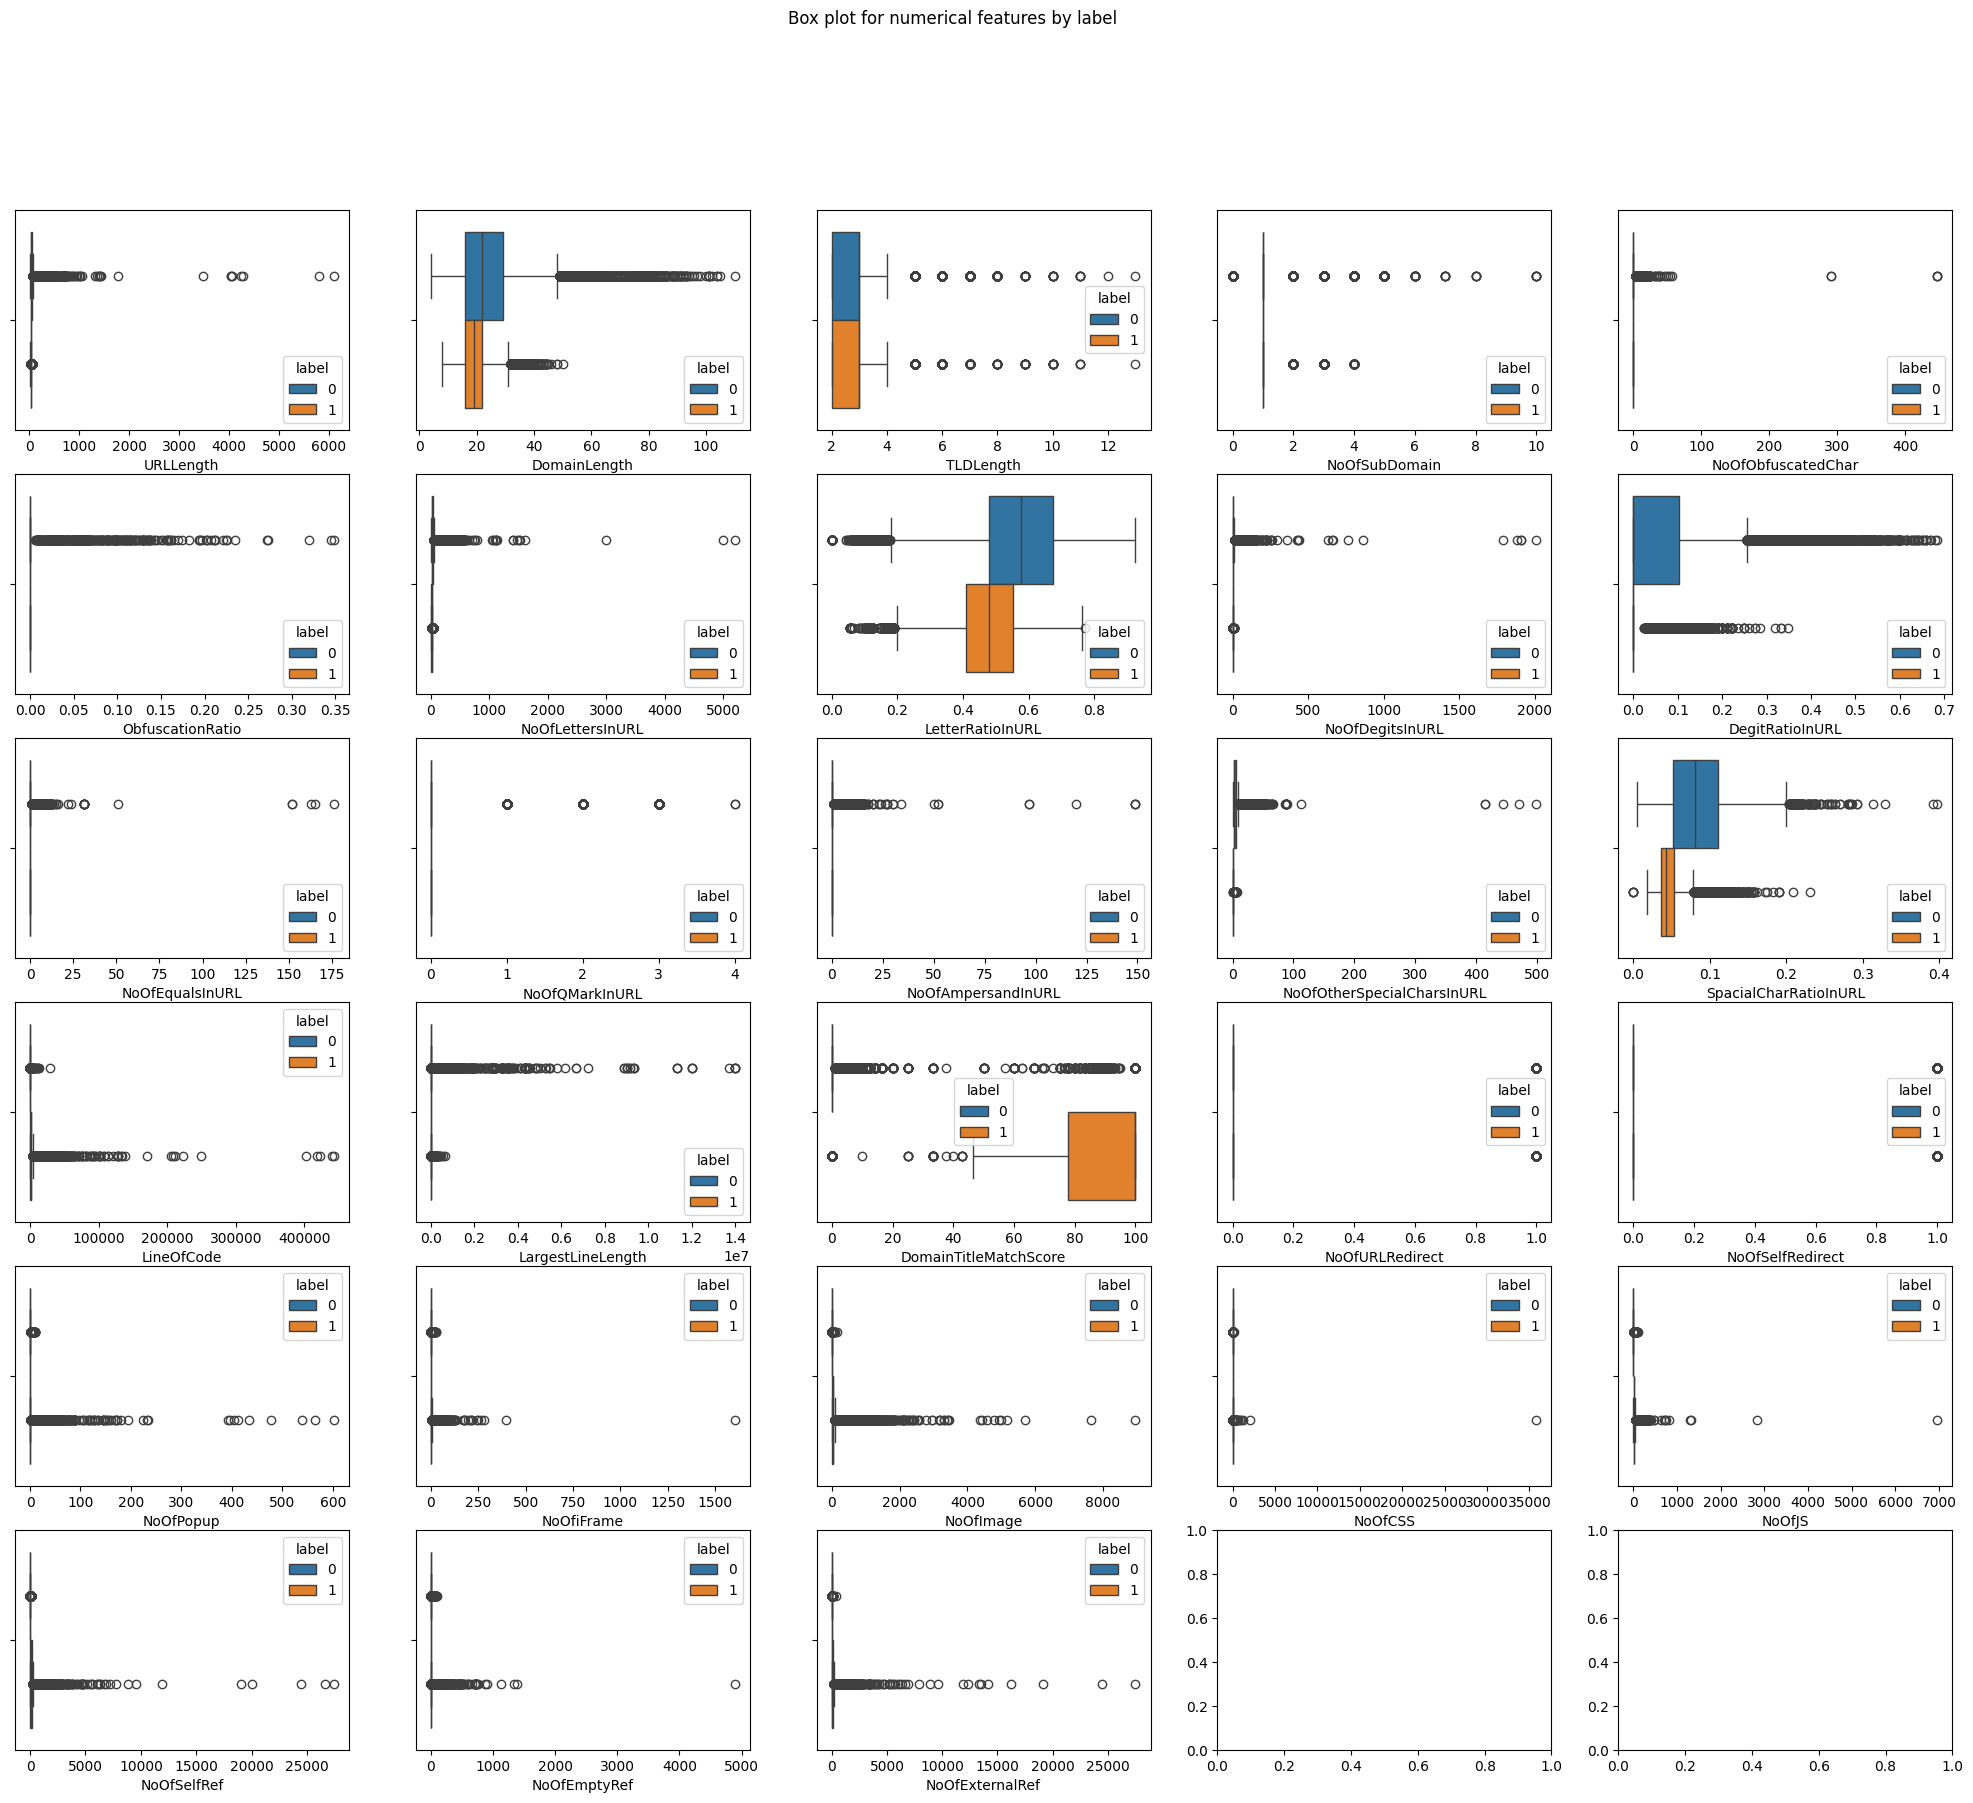

In [ ]:
fig, axs = plt.subplots(6, 5, figsize=(25, 20))
fig.suptitle('Box plot for numerical features by label')

for i, col in enumerate(col_numerical):
    sns.boxplot(x=col, hue='label', data=ds, ax=axs[i//5, i%5])

plt.show()

#### **2.5- Correlation**

##### 2.5.1- Pearson

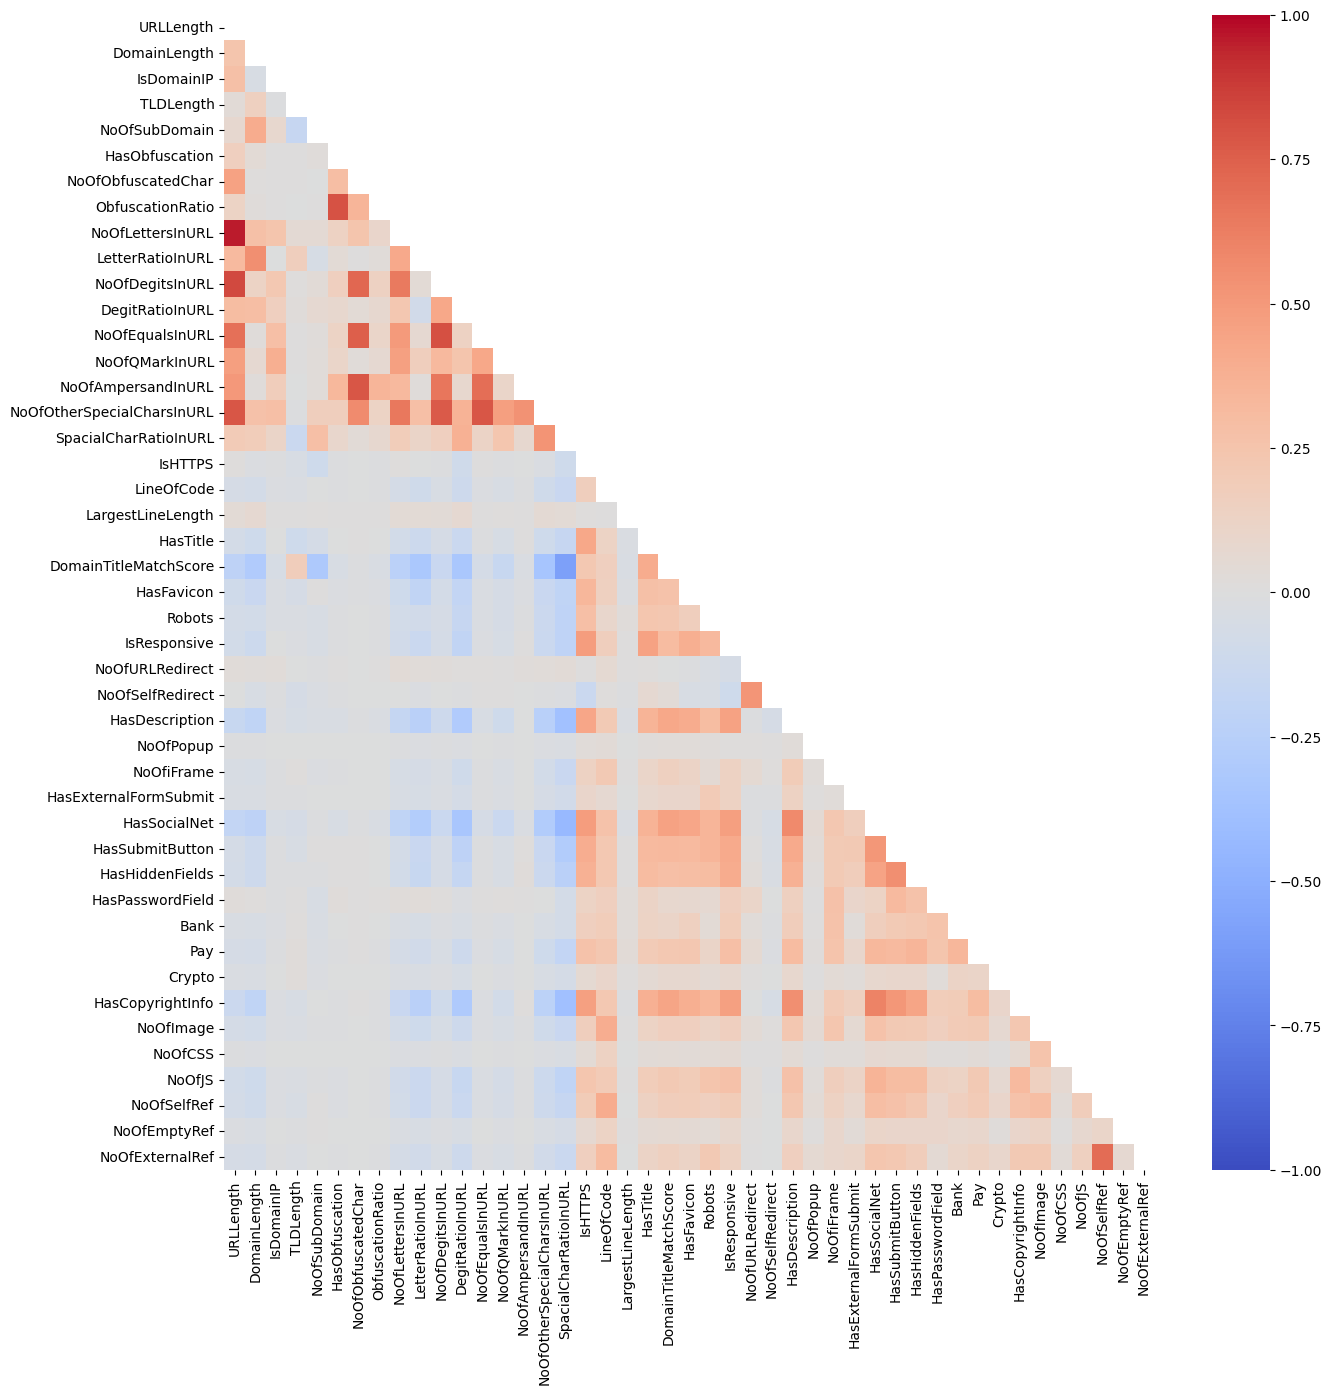

In [ ]:
# Correlation between numerical features

plt.figure(figsize=(15,15))

corr_pear = ds.drop(columns=col_categorical).corr()

mask = np.triu(np.ones_like(corr_pear.drop('label').drop(columns=['label']), dtype=bool))
sns.heatmap(corr_pear.drop('label').drop(columns=['label']), mask=mask, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

plt.show()

<p>We find high positive correlation between the url related features and between the code related feature<p>

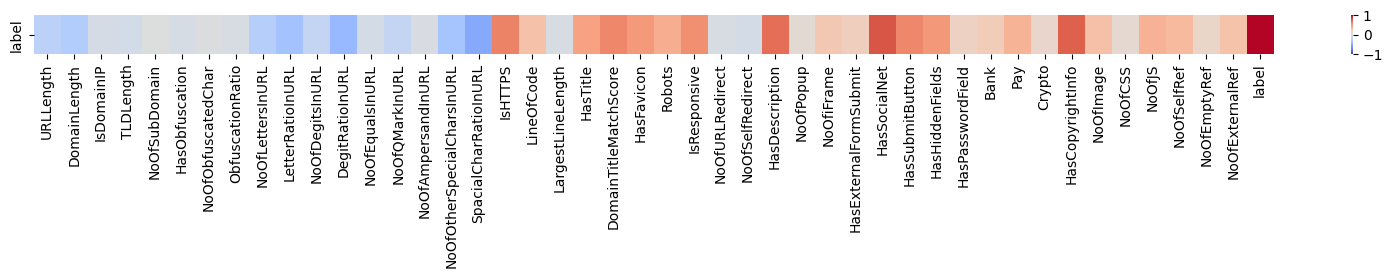

In [ ]:
# Correlation of label with all other numerical features

plt.figure(figsize=(20,0.5))
sns.heatmap(corr_pear[['label']].transpose(), vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

plt.show()

##### 2.5.2- Spearmann

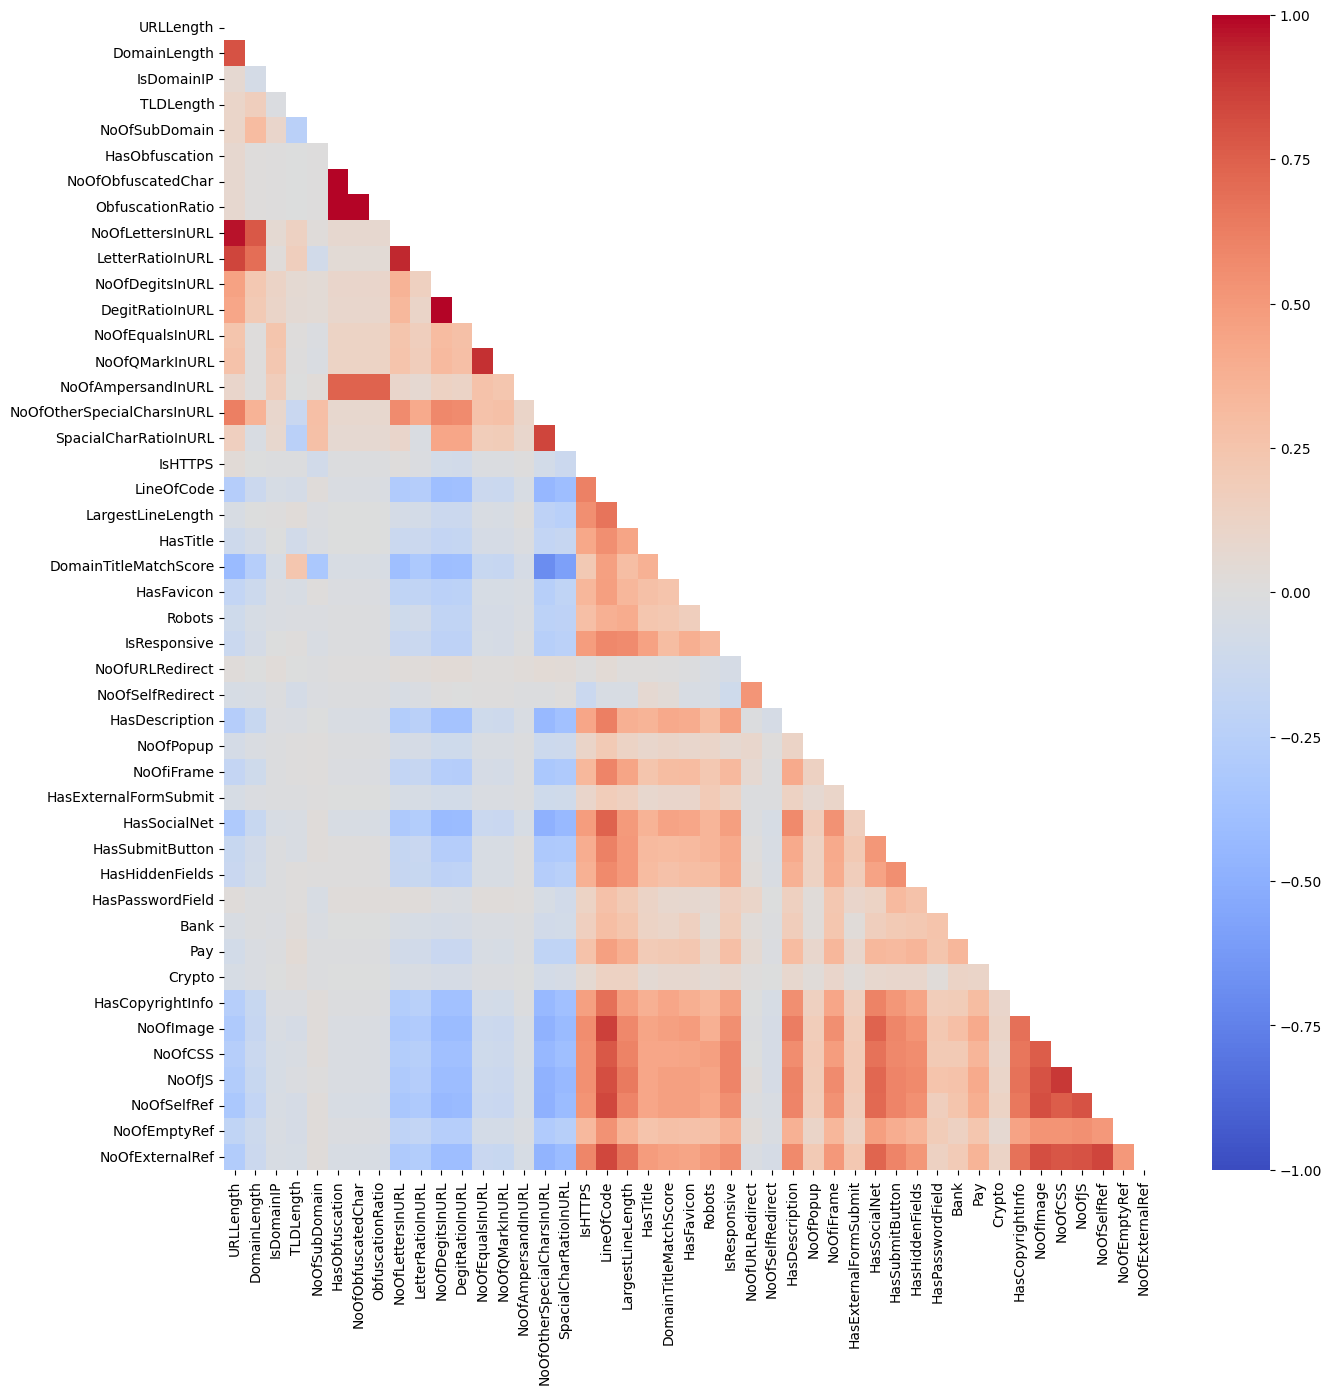

In [ ]:
# Correlation between numerical features

from scipy.stats import spearmanr

plt.figure(figsize=(15,15))

corr_spear = ds.drop(columns=col_categorical).corr(method='spearman')

mask = np.triu(np.ones_like(corr_spear.drop('label').drop(columns=['label']), dtype=bool))
sns.heatmap(corr_spear.drop('label').drop(columns=['label']), mask=mask, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

plt.show()

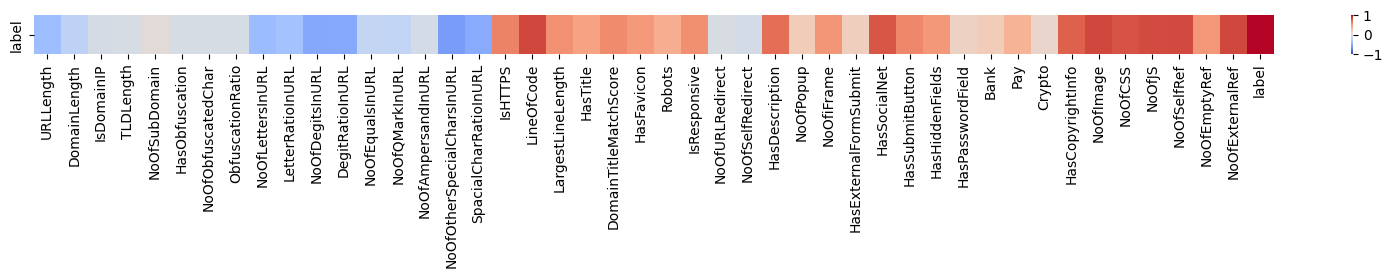

In [ ]:
# Correlation of label with all other numerical features

plt.figure(figsize=(20,0.5))
sns.heatmap(corr_spear[['label']].transpose(), vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

plt.show()

##### 2.5.3- Chi2 test

Correlation of categorical variables with the label

In [ ]:
# Calculate chi-squared stats
chi2_stats, p_values = chi2(ds[col_binary],ds['label'])

chi2_results = pd.DataFrame({
    'Feature': col_binary,
    'Chi2 Statistic': chi2_stats,
    'P-value': p_values
}).set_index('Feature')


<Axes: xlabel='Feature'>

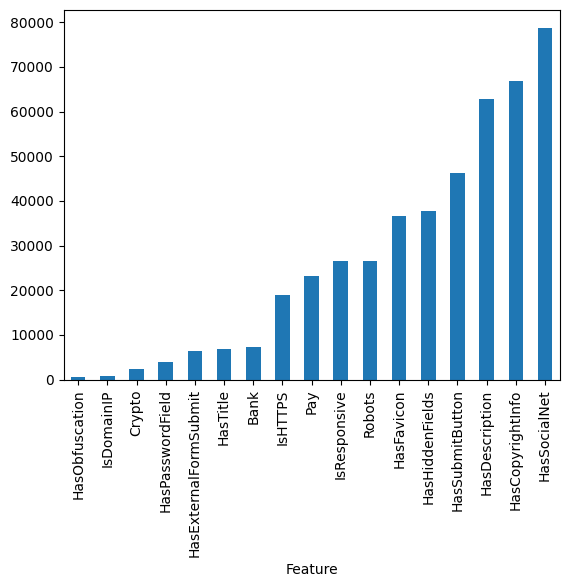

In [ ]:
# Show features sorted by importance
chi2_results.sort_values('Chi2 Statistic')['Chi2 Statistic'].plot(kind='bar')

#### **2-6- Data transformation**

In [ ]:
# We create a row cheking if the domain contains a word from english

def create_substring(s) :
    """return all possible substring of the string with more than 3 letters"""
    l = len(s)
    res = np.array([s[i:j] for i in range(l) for j in range(i+4, l+1)])
    res = np.unique(res)
    return res

In [ ]:
! pip install nltk

In [ ]:
import nltk
nltk.download('words')


[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [ ]:
from nltk.corpus import words
setofwords = set(words.words())

def check_domain(d) :
  sub_d = create_substring(d)

  for s in sub_d :
    if s in setofwords:
      return True

  return False

In [ ]:
ds['HasWordInDomain'] = ds['Domain'].apply(check_domain).replace({True:1, False:0})

<ipython-input-159-9040bcbf3ffe>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ds['HasWordInDomain'] = ds['Domain'].apply(check_domain).replace({True:1, False:0})


<Axes: xlabel='HasWordInDomain', ylabel='count'>

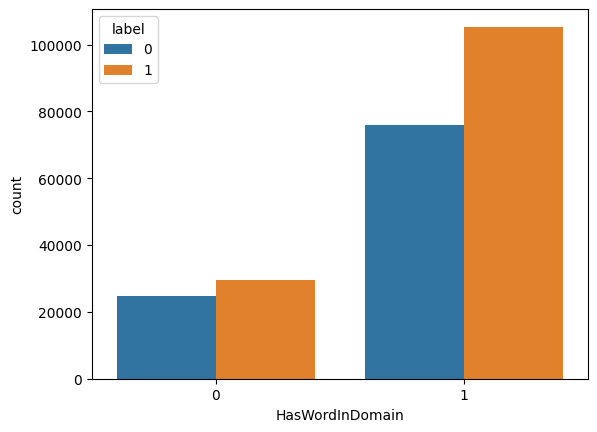

In [ ]:
# We check if it makes a difference
sns.countplot(x='HasWordInDomain', hue='label', data=ds)

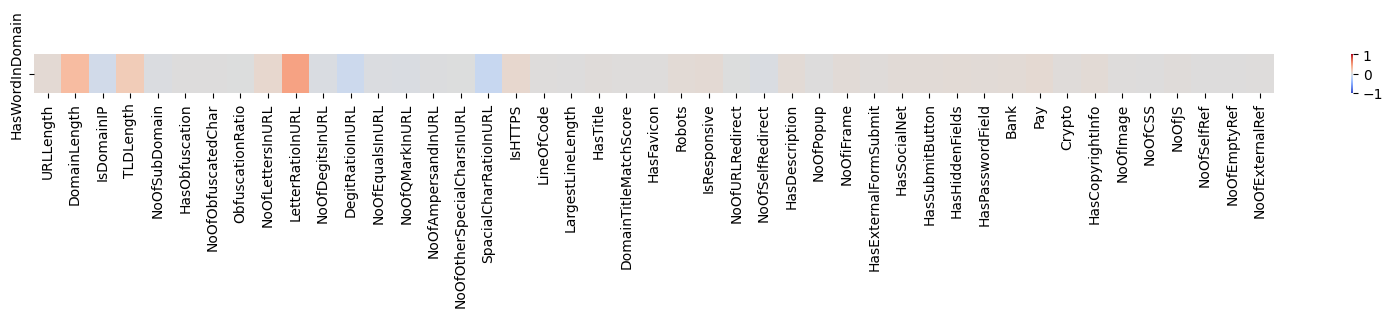

In [ ]:
# Correlation of label with all other numerical features

corr_word = ds.drop(columns=col_categorical).drop(columns=['label']).corr()

plt.figure(figsize=(20,0.5))
sns.heatmap(corr_word[['HasWordInDomain']][:-1].transpose(), vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

plt.show()


We add this feature to the X features dataset

In [ ]:
X['HasWordInDomain'] = ds['HasWordInDomain']

### **3- Benchmark of Classification Techniques & Prediction Model**

In [ ]:
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# We initialize the benchmark storing list
benchmark = []

In [ ]:
# Create the partitions for k-fold cross validation
def cross_validation_split(X, y, nfolds):
  # partition list of (X,y)
  partition = []

  i_list = [i for i in range(len(X))]
  np.random.shuffle(i_list)

  len_part = int(len(X)/nfolds)
  i_part_list = [i_list[k*len_part:(k+1)*len_part] for k in range(nfolds)]

  for i_part in i_part_list :
    partition.append([X.iloc[i_part], y.iloc[i_part]])

  return partition

In [ ]:
k=5

In [ ]:
def get_performances(y_test, y_pred):
    return {'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1-score': f1_score(y_test, y_pred) }

#### **3.1- Decision tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
X_dt = X.drop(columns=col_categorical).copy()
y_dt = y.copy()

In [ ]:
dt_perf= []

In [ ]:
def tree_cross(d) :

  ### We define our model

  dt_clf = DecisionTreeClassifier(max_depth = d, random_state=520)

  ### We start a k-fold cross fold validation (k=10)

  # To keep the performance score
  dt_cv = []

  # Get k partitions from the dateset, k=10
  dt_parts = cross_validation_split(X_dt, y_dt, k)

  # Iterate over the k partition
  for i in range(len(dt_parts)) :

    # The partition as the test set
    X_dt_test = dt_parts[i][0]
    y_dt_test = dt_parts[i][1]

    # Remaining partition as the train set
    X_dt_train = pd.concat([dt_parts[j][0] for j in range(len(dt_parts)) if j != i])
    y_dt_train = pd.concat([dt_parts[j][1] for j in range(len(dt_parts)) if j != i])

    # We fit the model on the train set (overwriting previous fit)
    dt_clf.fit(X_dt_train, y_dt_train)

    # We get the prediction from the test features set
    preds = dt_clf.predict(X_dt_test)

    # We compute the performance score compared to the test target set
    accuracy = accuracy_score(y_dt_test, preds)
    precision = precision_score(y_dt_test, preds)
    recall = recall_score(y_dt_test, preds)
    f1 = f1_score(y_dt_test, preds)

    # print the f1 score of this iteration
    print(f'{d}/ iter {i} : {f1}')

    # We store those performance score
    dt_cv.append([accuracy, precision, recall, f1])

  # We get the mean performance score
  return np.mean(dt_cv, axis=0)

In [ ]:
for d in range(2,11) :
  dt_perf.append(tree_cross(d))

2/ iter 0 : 0.983814215341309
2/ iter 1 : 0.9837007198537914
2/ iter 2 : 0.9853724149526425
2/ iter 3 : 0.9840715201754549
2/ iter 4 : 0.9840354767184035
3/ iter 0 : 0.9914460285132383
3/ iter 1 : 0.9906566360174608
3/ iter 2 : 0.9897953493559359
3/ iter 3 : 0.9900754562688177
3/ iter 4 : 0.9905767336393881
4/ iter 0 : 0.9932898450496253
4/ iter 1 : 0.9933836202902311
4/ iter 2 : 0.993046928596592
4/ iter 3 : 0.9933275096184228
4/ iter 4 : 0.9928933256638154
5/ iter 0 : 0.9941028113641421
5/ iter 1 : 0.99458614723447
5/ iter 2 : 0.9947686865866145
5/ iter 3 : 0.9942537313432835
5/ iter 4 : 0.9937219064601212
6/ iter 0 : 0.995154787883271
6/ iter 1 : 0.995850622406639
6/ iter 2 : 0.9957029079459159
6/ iter 3 : 0.9958550956301927
6/ iter 4 : 0.9954856614246068
7/ iter 0 : 0.9970543271561206
7/ iter 1 : 0.9971105180822674
7/ iter 2 : 0.9970485047613744
7/ iter 3 : 0.9974449176078504
7/ iter 4 : 0.997992863514719
8/ iter 0 : 0.9981266113924285
8/ iter 1 : 0.9981990679712593
8/ iter 2 : 0.9

<Axes: >

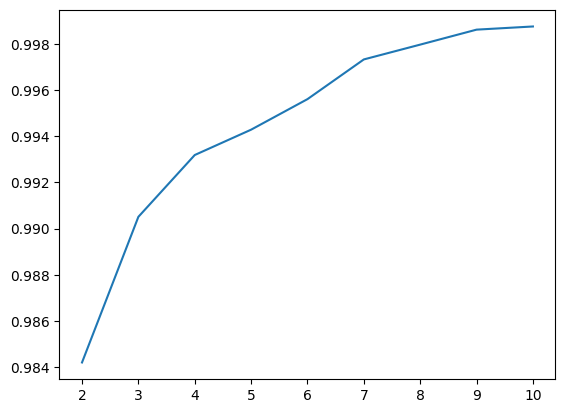

In [ ]:
sns.lineplot(x=range(2,11), y=[p[3] for p in dt_perf])

We choose 5 max depth with the elbow method

In [ ]:
### We define our model

dt_clf = DecisionTreeClassifier(max_depth = 5, random_state=520)

### We start a k-fold cross fold validation (k=10)

# To keep the performance score
dt5_cv = []

# Get k partitions from the dateset, k=10
dt_parts = cross_validation_split(X_dt, y_dt, k)

# Iterate over the k partition
for i in range(len(dt_parts)) :

  # The partition as the test set
  X_dt_test = dt_parts[i][0]
  y_dt_test = dt_parts[i][1]

  # Remaining partition as the train set
  X_dt_train = pd.concat([dt_parts[j][0] for j in range(len(dt_parts)) if j != i])
  y_dt_train = pd.concat([dt_parts[j][1] for j in range(len(dt_parts)) if j != i])

  # We fit the model on the train set (overwriting previous fit)
  dt_clf.fit(X_dt_train, y_dt_train)

  # We get the prediction from the test features set
  preds = dt_clf.predict(X_dt_test)

  # We compute the performance score compared to the test target set
  accuracy = accuracy_score(y_dt_test, preds)
  precision = precision_score(y_dt_test, preds)
  recall = recall_score(y_dt_test, preds)
  f1 = f1_score(y_dt_test, preds)

  # print the f1 score of this iteration
  print(f'iter {i} : {f1}')

  # We store those performance score
  dt5_cv.append([accuracy, precision, recall, f1])

# We get the mean performance score
dt5_cv = np.mean(dt5_cv, axis=0)

iter 0 : 0.9940808701120936
iter 1 : 0.9942630838700126
iter 2 : 0.9942739520958084
iter 3 : 0.9939876775310389
iter 4 : 0.9946601941747573


In [ ]:
dt5_cv

array([0.9934477 , 0.99751376, 0.991014  , 0.99425316])

In [ ]:
# We add the k-fold cross validation performance score to the benchmark
benchmark.append(np.concatenate((np.array(['Decision Tree']), dt5_cv)))

#### **3.2 - Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [ ]:
X_lr = ds[col_numerical].values
y_lr = y.values.ravel()

# Standardize data
std_scale = preprocessing.StandardScaler().fit(X_lr)
X_lr_scaled = std_scale.transform(X_lr)

In [ ]:
# split in train and test sets
X_lr_train, X_lr_test, y_lr_train, y_lr_test = train_test_split(X_lr_scaled,
                                                                y_lr,
                                                                test_size=0.3)

In [ ]:
# instantiate the model
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_lr_train, y_lr_train)

# predict unseen data
y_lr_pred = logreg.predict(X_lr_test)

In [ ]:
perfs = get_performances(y_lr_test, y_lr_pred)
print(perfs)

{'Accuracy': 0.9962396980449257, 'Precision': 0.9980133601529713, 'Recall': 0.9953931888544891, 'F1-score': 0.996701552502356}


In [ ]:
benchmark.append(np.array(['Logistic_regression',
                           perfs['Accuracy'],
                           perfs['Precision'],
                           perfs['Recall'],
                           perfs['F1-score']]))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [ ]:
X_lr = ds[col_numerical].values
y_lr = y.values.ravel()

# Standardize data
std_scale = preprocessing.StandardScaler().fit(X_lr)
X_lr_scaled = std_scale.transform(X_lr)

In [ ]:
# split in train and test sets
X_lr_train, X_lr_test, y_lr_train, y_lr_test = train_test_split(X_lr_scaled,
                                                                y_lr,
                                                                test_size=0.3)

In [ ]:
# instantiate the model
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_lr_train, y_lr_train)

# predict unseen data
y_lr_pred = logreg.predict(X_lr_test)

In [ ]:
perfs = get_performances(y_lr_test, y_lr_pred)
print(perfs)

{'Accuracy': 0.9967344746179618, 'Precision': 0.9981389578163772, 'Recall': 0.9961367970084941, 'F1-score': 0.997136872373917}


With cross validation

In [ ]:
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro']
logreg = LogisticRegression()
scores = cross_validate(logreg, X_lr_scaled, y_lr, scoring=scoring)


In [ ]:
scores

{'fit_time': array([0.81321216, 0.75006819, 0.80785418, 1.25240207, 0.7488513 ]),
 'score_time': array([0.11285448, 0.11383319, 0.11374569, 0.11371064, 0.11910105]),
 'test_accuracy': array([0.99675566, 0.99681927, 0.99620433, 0.99690409, 0.99641638]),
 'test_precision_macro': array([0.99650329, 0.9965182 , 0.99594665, 0.99671729, 0.99613356]),
 'test_recall_macro': array([0.99687708, 0.99699497, 0.99630789, 0.99696327, 0.99655555]),
 'test_f1_macro': array([0.99668841, 0.99675369, 0.99612561, 0.99683951, 0.99634228])}

In [ ]:
# Update benchmark
benchmark.append(np.array(['Logistic_regression',
                           scores['test_accuracy'].mean(),
                           scores['test_precision_macro'].mean(),
                           scores['test_recall_macro'].mean(),
                           scores['test_f1_macro'].mean()]))

 #### **3.3- SVM**

In [ ]:
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [ ]:
X_svm = X.drop(columns=col_categorical).copy()
y_svm = y.copy()

# Encode the target variable into numeric format for SVM compatibility
label_encoder = LabelEncoder()
y_svm = label_encoder.fit_transform(y_svm)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Split the data into training and testing sets (70% training, 30% testing)
X_svm_train, X_svm_test, y_svm_train, y_svm_test = train_test_split(X_svm,
                                                                    y_svm,
                                                                    test_size=0.3)

In [ ]:
# Standardize the features to have zero mean and unit variance
scaler = StandardScaler()
X_svm_train = scaler.fit_transform(X_svm_train)
X_svm_test = scaler.transform(X_svm_test)

In [ ]:
# Create and train a Linear Support Vector Classifier on the training data
svm_model = LinearSVC()
svm_model.fit(X_svm_train, y_svm_train)

# Make predictions on the test data
y_svm_pred = svm_model.predict(X_svm_test)

In [ ]:
perfs = get_performances(y_svm_test, y_svm_pred)
print(perfs)

benchmark.append(np.array(['SVM',
                           perfs['Accuracy'],
                           perfs['Precision'],
                           perfs['Recall'],
                           perfs['F1-score']]))


{'Accuracy': 0.9998303623178162, 'Precision': 0.999728950545795, 'Recall': 0.9999753530673108, 'F1-score': 0.9998521366257578}


 #### **3.4- Randon Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
X_rf = X.drop(columns=col_categorical).copy()
y_rf = y.copy()

In [ ]:
# We define our model
rf_clf = RandomForestClassifier()

### We start a k-fold cross fold validation (k=10)

# To keep the performance score
rf_cv = []

# Get k partitions from the dateset, k=10
rf_parts = cross_validation_split(X_rf, y_rf, k)

# Iterate over the k partition
for i in range(len(rf_parts)) :

  # The partition as the test set
  X_rf_test = rf_parts[i][0]
  y_rf_test = rf_parts[i][1]

  # Remaining partition as the train set
  X_rf_train = pd.concat([rf_parts[j][0] for j in range(len(rf_parts)) if j != i])
  y_rf_train = pd.concat([rf_parts[j][1] for j in range(len(rf_parts)) if j != i])

  # We fit the model on the train set (overwriting previous fit)
  rf_clf.fit(X_rf_train, y_rf_train)

  # We get the prediction from the test features set
  preds = rf_clf.predict(X_rf_test)

  # We compute the performance score compared to the test target set
  accuracy = accuracy_score(y_rf_test, preds)
  precision = precision_score(y_rf_test, preds)
  recall = recall_score(y_rf_test, preds)
  f1 = f1_score(y_rf_test, preds)

  # print the f1 score of this iteration
  print(f'iter {i} : {f1}')

  # We store those performance score
  rf_cv.append([accuracy, precision, recall, f1])

# We get the mean performance score
rf_cv = np.mean(rf_cv, axis=0)



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


iter 0 : 0.9998707795684038


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


iter 1 : 0.9998517200474496


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


iter 2 : 0.9999074022630887


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


iter 3 : 0.9999256533214379


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


iter 4 : 0.9998512734709054


In [ ]:
rf_cv

array([0.99986429, 0.99983684, 0.9999259 , 0.99988137])

In [ ]:
# We add the k-fold cross validation performance score to the benchmark
benchmark.append(np.concatenate((np.array(['RandonmForest']), rf_cv)))

#### **3.5- AdaBoost**

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
X_b = X.drop(columns=col_categorical).copy()
y_b = y.copy()

In [ ]:
### We define our model

b_clf = AdaBoostClassifier(n_estimators=100, random_state=520)

### We start a k-fold cross fold validation (k=10)

# To keep the performance score
b_cv = []

# Get k partitions from the dateset, k=10
b_parts = cross_validation_split(X_b, y_b, k)

# Iterate over the k partition
for i in range(len(b_parts)) :

  # The partition as the test set
  X_b_test = b_parts[i][0]
  y_b_test = b_parts[i][1]

  # Remaining partition as the train set
  X_b_train = pd.concat([b_parts[j][0] for j in range(len(b_parts)) if j != i])
  y_b_train = pd.concat([b_parts[j][1] for j in range(len(b_parts)) if j != i])

  # We fit the model on the train set (overwriting previous fit)
  b_clf.fit(X_b_train, y_b_train)

  # We get the prediction from the test features set
  preds = b_clf.predict(X_b_test)

  # We compute the performance score compared to the test target set
  accuracy = accuracy_score(y_b_test, preds)
  precision = precision_score(y_b_test, preds)
  recall = recall_score(y_b_test, preds)
  f1 = f1_score(y_b_test, preds)

  # print the f1 score of this iteration
  print(f'iter {i} : {f1}')

  # We store those performance score
  b_cv.append([accuracy, precision, recall, f1])

# We get the mean performance score
b_cv = np.mean(b_cv, axis=0)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


iter 0 : 0.9999442057691235


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


iter 1 : 0.9999814729041223


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


iter 2 : 0.9999256616116563


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


iter 3 : 0.9998889834585353


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


iter 4 : 0.9999445604568218


In [ ]:
b_cv

array([0.9999279 , 0.99989619, 0.99997777, 0.99993698])

In [ ]:
# We add the k-fold cross validation performance score to the benchmark
benchmark.append(np.concatenate((np.array(['AdaBoost']), b_cv)))

#### **3.6- Gradient Boosting**

In [ ]:
import xgboost as xgb

In [ ]:
X_xgb = X.copy()
y_xgb = y.copy()

In [ ]:
# Convert categorical data to category type
for col in col_categorical :
    X_xgb[col] = X_xgb[col].astype('category')


In [ ]:
### We define our model

xgb_clf = xgb.XGBClassifier(tree_method= "hist", enable_categorical=True, random_state=520)

### We start a k-fold cross fold validation (k=10)

# To keep the performance score
xgb_cv = []

# Get k partitions from the dateset, k=10
xgb_parts = cross_validation_split(X_xgb, y_xgb, k)

# Iterate over the k partition
for i in range(len(xgb_parts)) :

  # The partition as the test set
  X_xgb_test = xgb_parts[i][0]
  y_xgb_test = xgb_parts[i][1]

  # Remaining partition as the train set
  X_xgb_train = pd.concat([xgb_parts[j][0] for j in range(len(xgb_parts)) if j != i])
  y_xgb_train = pd.concat([xgb_parts[j][1] for j in range(len(xgb_parts)) if j != i])

  # We fit the model on the train set (overwriting previous fit)
  xgb_clf.fit(X_xgb_train, y_xgb_train)

  # We get the prediction from the test features set
  preds = xgb_clf.predict(X_xgb_test)

  # We compute the performance score compared to the test target set
  accuracy = accuracy_score(y_xgb_test, preds)
  precision = precision_score(y_xgb_test, preds)
  recall = recall_score(y_xgb_test, preds)
  f1 = f1_score(y_xgb_test, preds)

  # print the f1 score of this iteration
  print(f'iter {i} : {f1}')

  # We store those performance score
  xgb_cv.append([accuracy, precision, recall, f1])

# We get the mean performance score
xgb_cv = np.mean(xgb_cv, axis=0)

iter 0 : 0.9999444989177289
iter 1 : 0.9999072442259531
iter 2 : 0.9999629272632906
iter 3 : 0.9999629684491187
iter 4 : 0.9999070545589739


In [ ]:
xgb_cv

array([0.9999279 , 0.99990352, 0.99997036, 0.99993694])

In [ ]:
# We add the k-fold cross validation performance score to the benchmark
benchmark.append(np.concatenate((np.array(['XGBoost']), xgb_cv)))

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

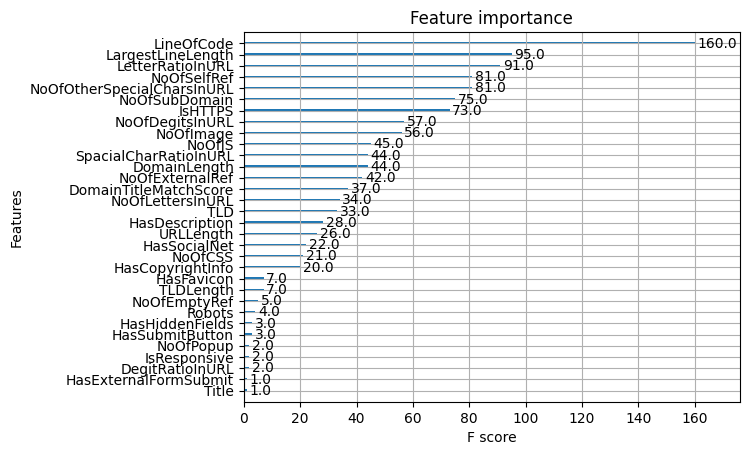

In [ ]:
# Importance of features (for the last iteration)
xgb.plot_importance(xgb_clf)

#### **3.7- Neural Networks and Deep Learning: MLP**

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
X_mlp = X.drop(columns=col_categorical).copy()
y_mlp = y.copy()

In [ ]:
# We define our model
mlp_clf = MLPClassifier(random_state=0, max_iter=1000)

### We start a k-fold cross fold validation (k=10)

# To keep the performance score
mlp_cv = []

# Get k partitions from the dateset, k=10
mlp_parts = cross_validation_split(X_mlp, y_mlp, k)

# Iterate over the k partition
for i in range(len(mlp_parts)) :

  # The partition as the test set
  X_mlp_test = mlp_parts[i][0]
  y_mlp_test = mlp_parts[i][1]

  # Remaining partition as the train set
  X_mlp_train = pd.concat([mlp_parts[j][0] for j in range(len(mlp_parts)) if j != i])
  y_mlp_train = pd.concat([mlp_parts[j][1] for j in range(len(mlp_parts)) if j != i])

  # We fit the model on the train set (overwriting previous fit)
  mlp_clf.fit(X_mlp_train, y_mlp_train)

  # We get the prediction from the test features set
  preds = mlp_clf.predict(X_mlp_test)

  # We compute the performance score compared to the test target set
  accuracy = accuracy_score(y_mlp_test, preds)
  precision = precision_score(y_mlp_test, preds)
  recall = recall_score(y_mlp_test, preds)
  f1 = f1_score(y_mlp_test, preds)

  # print the f1 score of this iteration
  print(f'iter {i} : {f1}')

  # We store those performance score
  mlp_cv.append([accuracy, precision, recall, f1])

# We get the mean performance score
mlp_cv = np.mean(mlp_cv, axis=0)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


iter 0 : 0.9994465965688988


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


iter 1 : 0.9988288439016229


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


iter 2 : 0.9993349098433343


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


iter 3 : 0.9982531777298744


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


iter 4 : 0.9982680596681379


In [ ]:
mlp_cv

array([0.99865985, 0.99904973, 0.99860347, 0.99882632])

In [ ]:
# We add the k-fold cross validation performance score to the benchmark
benchmark.append(np.concatenate((np.array(['MLP (Neural Network)']), mlp_cv)))

#### **3.8- Benchmark**

In [ ]:
bench_df = pd.DataFrame(benchmark, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])

In [ ]:
bench_df

,Model,Accuracy,Precision,Recall,F1
0,Decision Tree,0.9934476982124304,0.9975137569893618,0.9910140024518718,0.994253155556742
1,Logistic_regression,0.9962396980449257,0.9980133601529713,0.9953931888544891,0.996701552502356
2,Logistic_regression,0.9966199452914608,0.9963637978286617,0.9967397493023519,0.9965499022818216
3,SVM,0.9998303623178162,0.999728950545795,0.9999753530673108,0.9998521366257578
4,RandonmForest,0.9998642888950148,0.9998368428981583,0.9999258960183584,0.999881365734257
5,AdaBoost,0.9999279034754766,0.9998961857839312,0.9999777721585825,0.9999369768400518
6,XGBoost,0.9999279034754766,0.9999035196321671,0.9999703647492009,0.999936938683013
7,MLP (Neural Network),0.9986598528382705,0.999049730711777,0.9986034745792278,0.9988263175423736


### **4- Consideration of additional features**

In this part, we will show the impact of the previously removed features URLSimilarityIndex, CharContinuationRate, URLTitleMatchScore, URLCharProb, and TLDLegitimateProb onto your best model’s performances with a sensitivity analysis.

In [ ]:
# On importe de nouveau nos données
from ucimlrepo import fetch_ucirepo

# fetch dataset
repo = fetch_ucirepo(id=967)

# data (as pandas dataframes)
X = repo.data.features
y = repo.data.targets

As all algorithms give nearly the same high F1 score, let's show the impact of the variables using a decision tree.

In [ ]:
X = X.drop(columns=col_categorical)

In [ ]:
### We define our model

dt_clf = DecisionTreeClassifier(max_depth = 3, random_state=520)

### We start a k-fold cross fold validation (k=10)

# To keep the performance score
dt_cv = []

# Get k partitions from the dateset, k=10
dt_parts = cross_validation_split(X, y, k)

# Iterate over the k partition
for i in range(len(dt_parts)) :

  # The partition as the test set
  X_dt_test = dt_parts[i][0]
  y_dt_test = dt_parts[i][1]

  # Remaining partition as the train set
  X_dt_train = pd.concat([dt_parts[j][0] for j in range(len(dt_parts)) if j != i])
  y_dt_train = pd.concat([dt_parts[j][1] for j in range(len(dt_parts)) if j != i])

  # We fit the model on the train set (overwriting previous fit)
  dt_clf.fit(X_dt_train, y_dt_train)

  # We get the prediction from the test features set
  preds = dt_clf.predict(X_dt_test)

  # We compute the performance score compared to the test target set
  accuracy = accuracy_score(y_dt_test, preds)
  precision = precision_score(y_dt_test, preds)
  recall = recall_score(y_dt_test, preds)
  f1 = f1_score(y_dt_test, preds)

  # print the f1 score of this iteration
  print(f'iter {i} : {f1}')

  # We store those performance score
  dt_cv.append([accuracy, precision, recall, f1])

# We get the mean performance score
dt_cv = np.mean(dt_cv, axis=0)

iter 0 : 1.0
iter 1 : 1.0
iter 2 : 0.9999814309323529
iter 3 : 1.0
iter 4 : 0.9999814543498823


In [ ]:
dt_cv

array([0.99999152, 0.99998515, 1.        , 0.99999258])

**CONCLUSION:** **With trees of only depth 3, we achieve better performance than all previous models.**

## **Phase 2: Competition**

Two datasets were be provided to allow us evaluate the performance of our best model by calculating a score and establishing a ranking.

However, during testing, we observed that most models achieved very high scores, making ranking nearly impossible. To address this, we focused on finding the simplest solution that still maintains high performance, in line with **the principle of parsimony advocated by Occam's Razor**.

### **1st approach: Decision tree, the simplest model (F1-score = 0.99)**

#### **1- Import of the Datasets**

In [ ]:
# We import the train Dataset
ds_train = pd.read_csv('/content/Training_for_evaluation')
ds_train = ds_train.drop(columns=['Unnamed: 0', 'FILENAME', 'URLSimilarityIndex', 'CharContinuationRate', 'URLTitleMatchScore', 'URLCharProb', 'TLDLegitimateProb'])
ds_train['HasWordInDomain'] = ds_train['Domain'].apply(check_domain).replace({True:1, False:0})

X_train = ds_train.drop(columns=['label'])
y_train = ds_train['label']

# We import the test Dataset
ds_test = pd.read_csv('/content/Testing_for_evaluation')
ds_test = ds_test.drop(columns=['Unnamed: 0', 'FILENAME', 'URLSimilarityIndex', 'CharContinuationRate', 'URLTitleMatchScore', 'URLCharProb', 'TLDLegitimateProb'])
ds_test['HasWordInDomain'] = ds_test['Domain'].apply(check_domain).replace({True:1, False:0})

X_test = ds_test.drop(columns=['label'])
y_test = ds_test['label']


<ipython-input-240-32edd85c06cd>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ds_train['HasWordInDomain'] = ds_train['Domain'].apply(check_domain).replace({True:1, False:0})
<ipython-input-240-32edd85c06cd>:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ds_test['HasWordInDomain'] = ds_test['Domain'].apply(check_domain).replace({True:1, False:0})


#### **2- Training**

<Axes: xlabel='label', ylabel='count'>

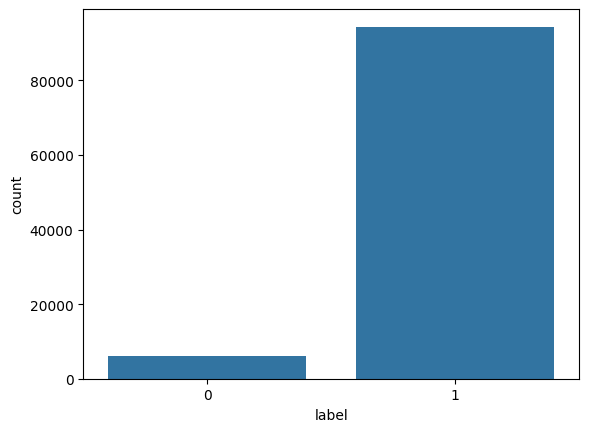

In [ ]:
sns.countplot(x='label', data=ds_train)

The class of phising site is under-represented, we adjust the class weight in our model

In [ ]:
X_train = X_train.drop(columns=col_categorical)

In [ ]:
clf = DecisionTreeClassifier(max_depth = 5, class_weight = 'balanced', random_state=520)

In [ ]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=520)

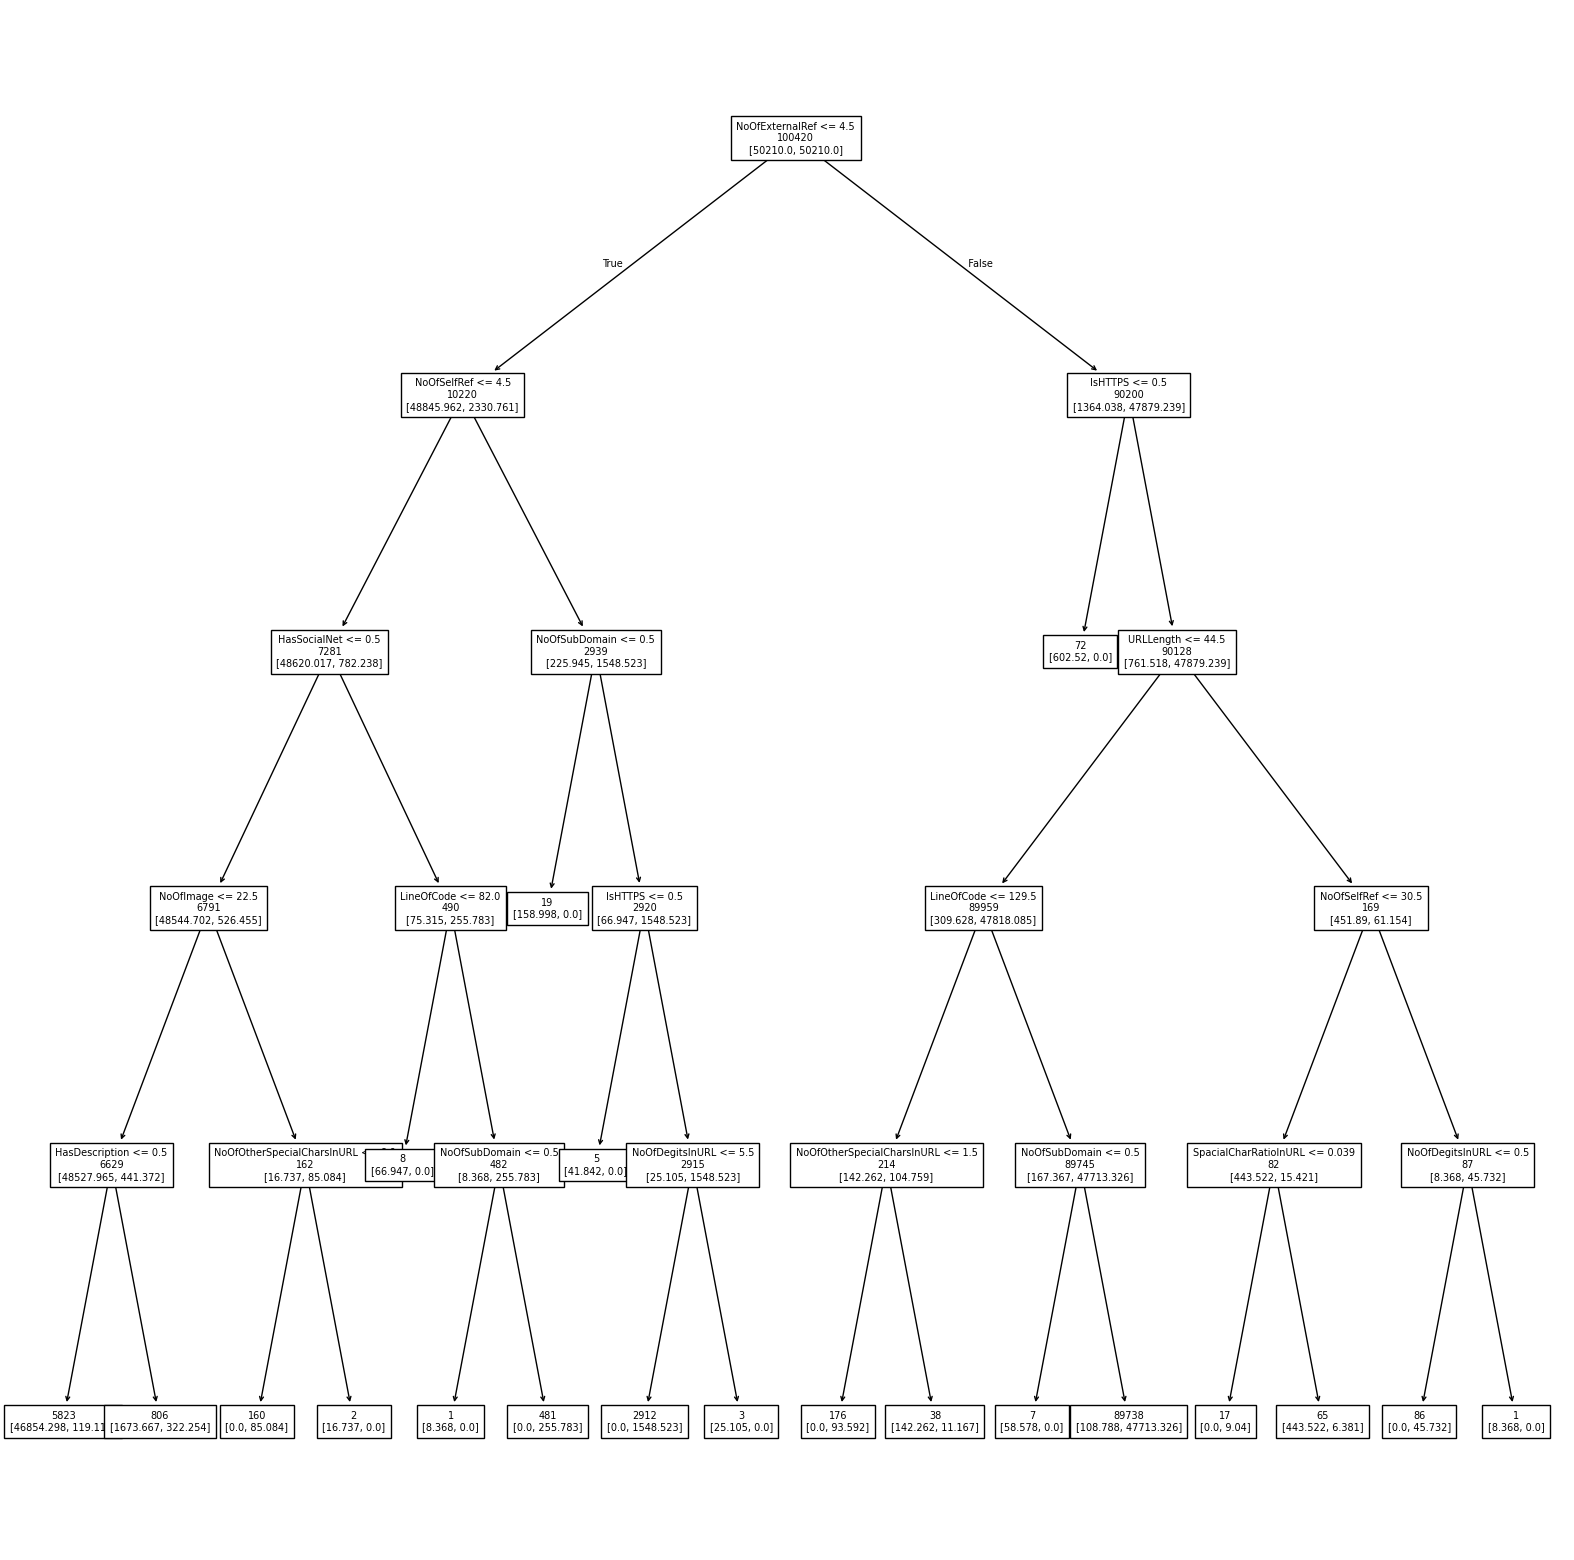

In [ ]:
from sklearn import tree

plt.figure(figsize=(20,20))
tree.plot_tree(clf, feature_names=X_train.columns, label='none', impurity=False, fontsize=7)
plt.show()

#### **3- Test**

In [ ]:
X_test = X_test.drop(columns=col_categorical)

In [ ]:
# We get the prediction from the test features set
preds = clf.predict(X_test)

In [ ]:
# We compute the performance score compared to the test target set
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)

In [ ]:
perf = pd.DataFrame([[accuracy, precision, recall, f1]], columns=['Accuracy', 'Precision', 'Recall', 'F1'])

In [ ]:
perf

,Accuracy,Precision,Recall,F1
0,0.993243,0.997039,0.99112,0.994071


### **2nd Approach: Minimizing the Number of Features for High F1 Score Detection (Achieved F1 Score = 0.97 with One Column)**

This approach aims to reduce the number of features required to achieve a high F1 score for phishing detection. By focusing on the most relevant features, we simplify the model while maintaining robust performance.


#### **1- Import of the Datasets**

In [ ]:
# We import the train Dataset
df_train = pd.read_csv('/content/Training_for_evaluation')
df_train = df_train.drop(columns=['Unnamed: 0', 'FILENAME', 'URLSimilarityIndex', 'CharContinuationRate', 'URLTitleMatchScore', 'URLCharProb', 'TLDLegitimateProb'])

# We import the test Dataset
df_test = pd.read_csv('/content/Testing_for_evaluation')
df_test = df_test.drop(columns=['Unnamed: 0', 'FILENAME', 'URLSimilarityIndex', 'CharContinuationRate', 'URLTitleMatchScore', 'URLCharProb', 'TLDLegitimateProb'])

def feature_selector_correlation(corr_matrix, threshold):

   selected_features = [
        (feature, f"{score:.3f}")
        for feature, score in corr_matrix.items()
        if abs(score) > threshold
    ]

   return selected_features

#### **2. Correlation-Based Feature Selection**

First, we identify and select features based on their correlation with the label

In [ ]:
# Select only numerical features
numerical_df_train = df_train.select_dtypes(include=['float64', 'int64'])
corr_matrix = numerical_df_train.corr()


# Calculate correlation with the label specifically
corr_with_label = corr_matrix["label"]
features_selected = feature_selector_correlation(corr_with_label, 0.30)
features_selected

[('URLLength', '-0.331'),
 ('NoOfLettersInURL', '-0.332'),
 ('NoOfDegitsInURL', '-0.347'),
 ('DegitRatioInURL', '-0.477'),
 ('NoOfOtherSpecialCharsInURL', '-0.489'),
 ('SpacialCharRatioInURL', '-0.377'),
 ('IsHTTPS', '0.698'),
 ('HasTitle', '0.538'),
 ('DomainTitleMatchScore', '0.313'),
 ('IsResponsive', '0.332'),
 ('HasDescription', '0.357'),
 ('HasSocialNet', '0.431'),
 ('HasCopyrightInfo', '0.419'),
 ('label', '1.000')]

#### **3. Composite Feature Engineering**


To simplify the feature set, we create two composite scores based on selected positively and negatively correlated features:

- **TrustScore**: Measures the trustworthiness of a URL based on positively correlated features.
- **SuspicionScore**: Measures suspicion based on negatively correlated features.

Finally, we compute a composite feature, **PhishingRiskScore**, as the difference between `SuspicionScore` and `TrustScore`.


In [ ]:
# Define Trust Indicator (Positively correlated features)
df_train['TrustScore'] = (
    0.4 * df_train['IsHTTPS'] +          # High correlation with label
    0.3 * df_train['HasTitle'] +
    0.2 * df_train['HasSocialNet'] +
    0.1 * df_train['HasCopyrightInfo']
)

# Define Suspicion Indicator (Negatively correlated features)
df_train['SuspicionScore'] = (
    0.3 * df_train['DegitRatioInURL'] +
    0.3 * df_train['NoOfOtherSpecialCharsInURL'] +
    0.2 * df_train['SpacialCharRatioInURL'] +
    0.2 * df_train['NoOfDegitsInURL']
)

# Compute Phishing Risk Score
df_train['PhishingRiskScore'] = df_train['SuspicionScore'] - df_train['TrustScore']

# Apply same feature engineering to test set
df_test['TrustScore'] = (
    0.4 * df_test['IsHTTPS'] +
    0.3 * df_test['HasTitle'] +
    0.2 * df_test['HasSocialNet'] +
    0.1 * df_test['HasCopyrightInfo']
)

df_test['SuspicionScore'] = (
    0.3 * df_test['DegitRatioInURL'] +
    0.3 * df_test['NoOfOtherSpecialCharsInURL'] +
    0.2 * df_test['SpacialCharRatioInURL'] +
    0.2 * df_test['NoOfDegitsInURL']
)

df_test['PhishingRiskScore'] = df_test['SuspicionScore'] - df_test['TrustScore']


#### **4. Training**

With `PhishingRiskScore` as our single, simplified feature, we prepare the data for model training.


In [ ]:
# Select the composite feature for training
selected_features = ["PhishingRiskScore"]

X = df_train[selected_features]
y = df_train['label']


We split the dataset into training, validation, and test sets.


In [ ]:
from sklearn.model_selection import train_test_split
# Split into training (70%), validation (15%), and test (15%) sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = df_test[selected_features]
y_test = df_test['label']


To ensure consistent scaling across features, we apply standard scaling.

In [ ]:
from sklearn.preprocessing import StandardScaler
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


We use a `RandomForestClassifier` with a grid search for hyperparameter tuning, aiming to find the best-performing model through cross-validation.



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score
#Define Random Forest classifier with chosen hyperparameters
clf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)

# Train the model on the scaled training set
clf.fit(X_train_scaled, y_train)

# Evaluate on the validation set
val_accuracy = accuracy_score(y_val, clf.predict(X_val_scaled))
print(f"Validation Accuracy for Random Forest: {val_accuracy:.4f}")

Validation Accuracy for Random Forest: 0.9930


#### **5. Testing**


In [ ]:
# Test set evaluation
print("\n--- Test Set Evaluation ---")
y_pred = clf.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred)
test_f1_score = f1_score(y_test, y_pred)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1_score:.4f}")


--- Test Set Evaluation ---
Test Accuracy: 0.9698
Test F1 Score: 0.9742
